In [1]:
library(reshape2)
library(lubridate)
library(tseries)
library(MASS,stats)
library(car)
library(fGarch)

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: carData

NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")



In [2]:
data <- read.csv("SP500.csv")
head(data)

,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,20060103,0.016341,0.016340,0.015027,0.015023,11699545700,500,11540511600,500,1268.80,0.016430
2,20060104,0.003931,0.003736,0.006375,0.006284,11740829600,499,11697131300,499,1273.46,0.003673
3,20060105,0.000028,0.000021,0.000621,0.000611,11745619900,500,11745378700,500,1273.48,0.000016
4,20060106,0.009559,0.009322,0.010100,0.009988,11855262700,500,11745619900,500,1285.45,0.009399
5,20060109,0.003710,0.003708,0.005676,0.005673,11899300800,500,11855262700,500,1290.15,0.003656
6,20060110,-0.000340,-0.000394,0.000430,0.000379,11894617400,500,11899300800,500,1289.69,-0.000357


In [3]:
Ret <- data$sprtrn
y  <- as.matrix(Ret)
dates <- ymd(data$caldt)

In [4]:
n <- dim(y)[1]
# Initializing the EWMA matrix
EWMA <- matrix(NA, nrow = n, ncol = 3)
# Determine lambda
lambda <- 0.94

In [5]:
S <- cov(y)
S

0.0002766451


In [6]:
# Fill the initial row of EWMA with the sample covariances
EWMA[1,] <- S[upper.tri(S, diag = TRUE)]

# Manually computing EWMA elements for t = 2

# Apply the formula for EWMA
S_2 <- lambda * S + (1-lambda) * y[1,] %*% t(y[1,])
# Get the variances and covariances
S_2[upper.tri(S_2, diag = TRUE)]

# Populating the EWMA matrix

# Create a loop for rows 2 to n
for (i in 2:n) {
    # Update S with the new weighted moving average
    S <- lambda * S + (1-lambda) * y[i-1,] %*% t(y[i-1,])
    
    # Fill the following EWMA row with the covariances
    EWMA[i,] <- S[upper.tri(S, diag = TRUE)]
}

head(EWMA)

[1] 0.0002762431

0.0002766451,0.0002766451,0.0002766451
0.0002762431,0.0002762431,0.0002762431
0.0002604779,0.0002604779,0.0002604779
0.0002448493,0.0002448493,0.0002448493
0.0002354588,0.0002354588,0.0002354588
0.0002221332,0.0002221332,0.0002221332


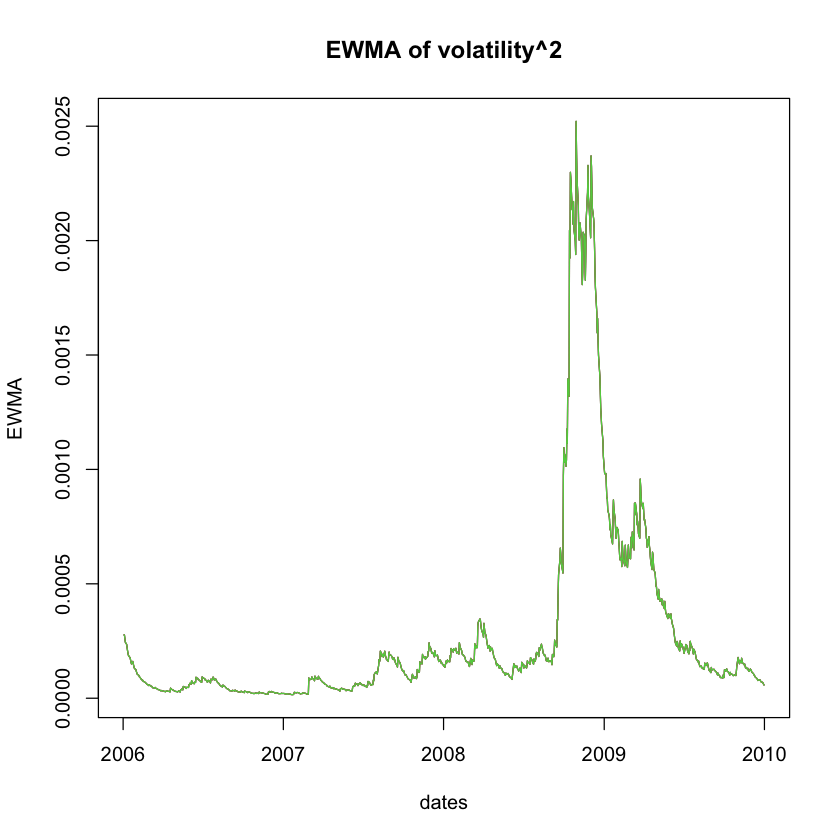

In [7]:
# Plotting estimated variances and covariances
matplot(dates, EWMA, type = "l", main = "EWMA of volatility^2", lty = 1)

In [8]:
# Implementing EWMA VaR

# Specifying the parameters for VaR
p <- 0.05
portfolio_value <- 1000

# Specifying the parameters for EWMA
lambda <- 0.94
n <- length(y)
BurnTime <- 30

# Vector to store estimated conditional volatility
EWMA_Variance <- rep(NA, length = n)

# First value is the sample variance
EWMA_Variance[1] <- var(y)

# See the vector
head(EWMA_Variance)

[1] 0.0002766451           NA           NA           NA           NA
[6]           NA

In [9]:
# Run the EWMA model using a for loop
for (i in 2:n) {
    EWMA_Variance[i] <- lambda * EWMA_Variance[i-1] + (1-lambda) * y[i-1]^2
}

In [10]:
# Replacing the data in the estimation window to NA
EWMA_Variance[1:BurnTime] <- NA

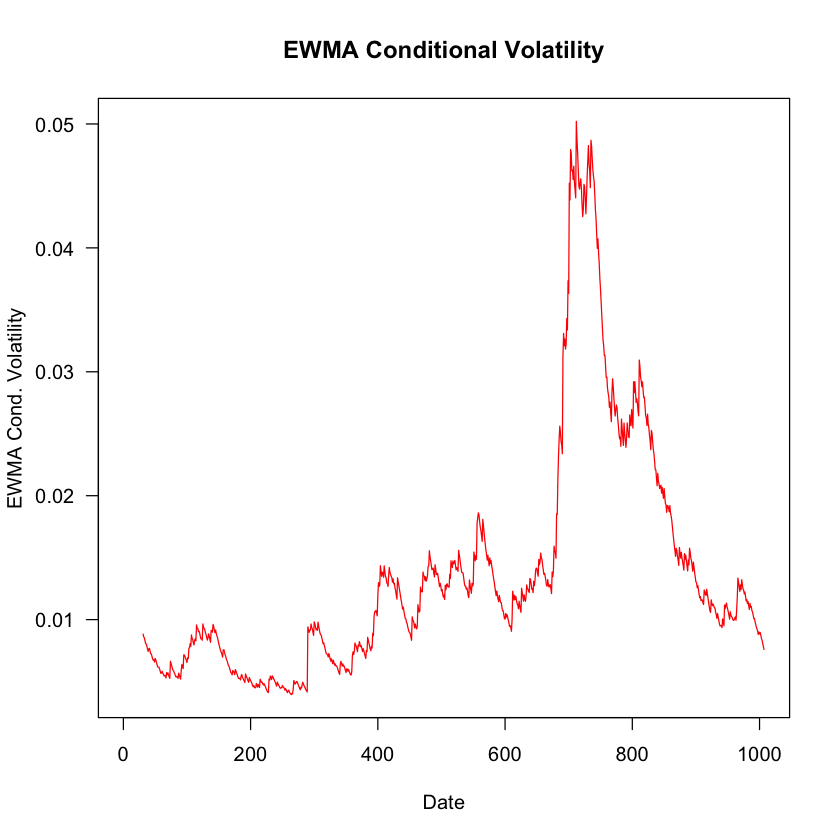

In [11]:
# Plot estimation for conditional volatility
EWMA_cond_volatility <- sqrt(EWMA_Variance)
plot(EWMA_cond_volatility, type = "l", main = "EWMA Conditional Volatility",
    las = 1, col = "red", xlab = "Date", ylab = "EWMA Cond. Volatility")

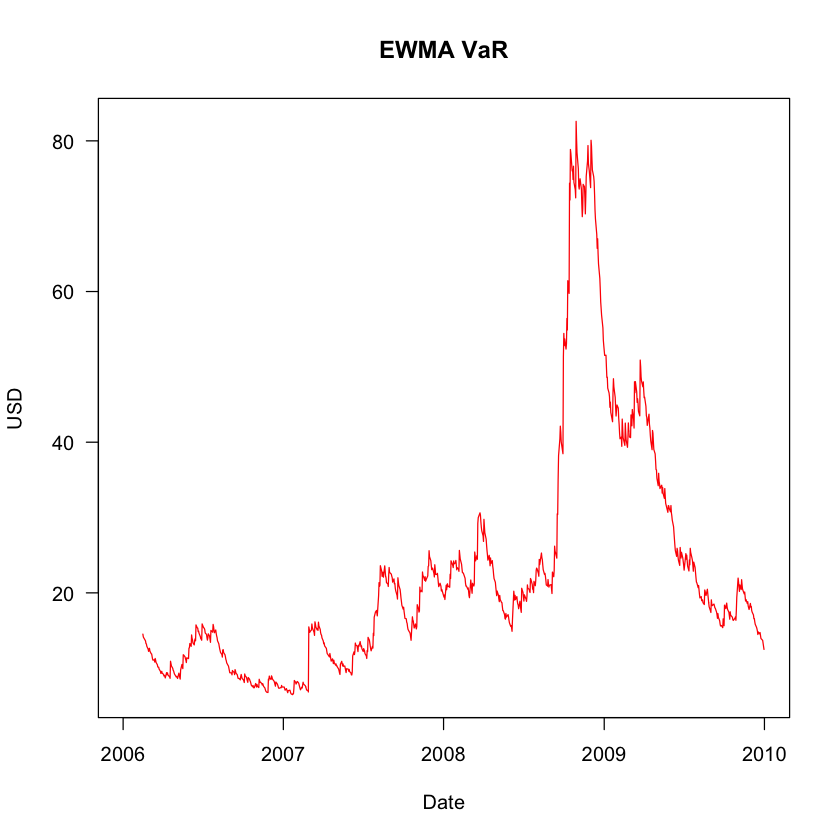

In [12]:
# Implementing the VaR forecast
EWMA_VaR <- -qnorm(p) * EWMA_cond_volatility * portfolio_value

# Plotting it
plot(dates, EWMA_VaR, type = "l", main = "EWMA VaR",
    las = 1, col = "red", xlab = "Date", ylab = "USD")

In [13]:
print(EWMA_VaR)

   [1]        NA        NA        NA        NA        NA        NA        NA
   [8]        NA        NA        NA        NA        NA        NA        NA
  [15]        NA        NA        NA        NA        NA        NA        NA
  [22]        NA        NA        NA        NA        NA        NA        NA
  [29]        NA        NA 14.525360 14.153446 14.036311 13.625134 13.275635
  [36] 13.222361 12.909466 12.526713 12.233181 12.579068 12.641883 12.274256
  [43] 11.915304 11.888555 11.550770 11.228714 11.062840 11.127015 10.817795
  [50] 11.293697 11.083977 10.770031 10.458738 10.162156 10.146255 10.131863
  [57]  9.878137  9.585395  9.302611  9.384806  9.583758  9.327585  9.198026
  [64]  8.965877  9.050915  8.945436  8.707389  9.414641  9.134240  9.388461
  [71]  9.115389  8.843226  8.655266 10.925617 10.616059 10.303403  9.989672
  [78]  9.734181  9.639452  9.414559  9.224198  8.947387  8.833346  8.914940
  [85]  8.798437  8.637406  9.345247  9.066723  8.791724  8.552278  9.764284

In [14]:
print(sqrt(var(Ret)))

[1] 0.01663265
